In [124]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *

In [125]:
#data path
_folder_name = "sk13_random_t0"

_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", "single_cam_oct_21")
_pth = os.path.join(_base_pth, _folder_name)
_base_pth 


'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\single_cam_oct_21'

In [126]:
#calibration path
_calib_pth = os.path.join(_base_pth, "calibration11")
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_rotmat_pth = _calib_pth
_webcam_rotmat_pth = os.path.join(_rotmat_pth, "webcam_rotmat.msgpack")
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

#timestamp path
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")
_webcam_calib_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\single_cam_oct_21\\calibration11\\webcam_calibration.msgpack'

In [127]:
#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
    
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)

camera matrix [[854.18206253   0.         346.3795027 ]
 [  0.         864.65874931 268.01454777]
 [  0.           0.           1.        ]]
distortion [[ 1.02169014e-01 -1.48557867e-01 -1.21573114e-03 -2.95257573e-03
  -3.29111851e+00]]


In [128]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe


In [129]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "sk13",_folder_name + ".csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["lb_x"] + _m_df["rb_x"] + _m_df["lt_x"] + _m_df["rt_x"]
_m_df["y"] = _m_df["lb_y"] + _m_df["rb_y"] + _m_df["lt_y"] + _m_df["rt_y"]
_m_df["z"] = _m_df["lb_z"] + _m_df["rb_z"] + _m_df["lt_z"] + _m_df["rt_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

# _m_df["x"] = _m_df["LT_x"] + _m_df["RT_x"]
# _m_df["y"] = _m_df["LT_y"] + _m_df["RT_y"]
# _m_df["z"] = _m_df["LT_z"] + _m_df["RT_z"]

# _m_df["x"] = _m_df["x"] / 2
# _m_df["y"] = _m_df["y"] / 2
# _m_df["z"] = _m_df["z"] / 2

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [130]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [131]:
# offset = np.array([-0.157, -0.005, -0.28])
offset = np.array([0, 0, 0])

In [132]:

w_df = None

w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

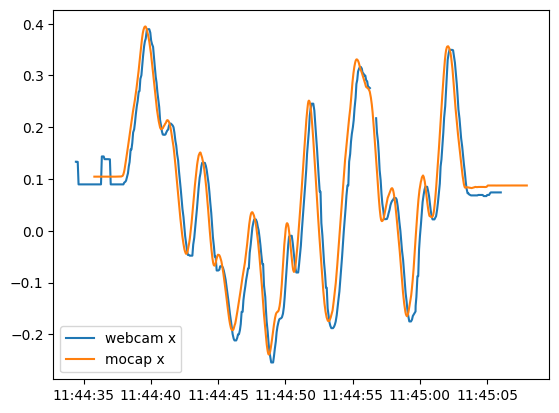

In [133]:

plt.plot(_w_df["time"], w_df["x"].rolling(5).median()+ offset[0], label="webcam x")
# plt.plot(_w_df["time"], w_df["x"], label="webcam x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()

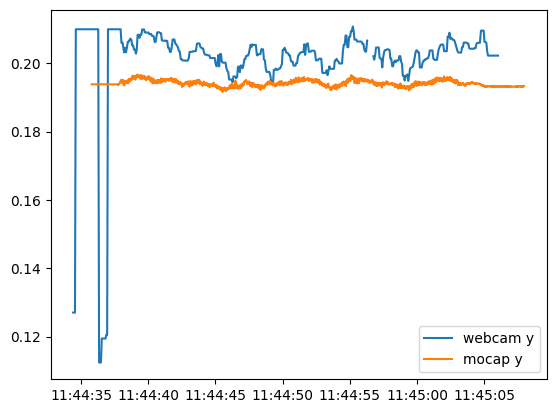

In [134]:

plt.plot(_w_df["time"], w_df["y"].rolling(5).median() + offset[1], label="webcam y")
# plt.plot(_w_df["time"], w_df["y"] + offset[1], label="webcam y")
plt.plot(_m_df["time"], _m_df["y"], label="mocap y")
plt.legend()

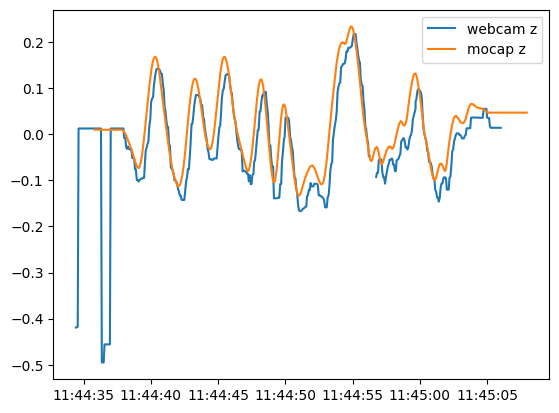

In [135]:
plt.plot(_w_df["time"], w_df["z"].rolling(5).median() + offset[2], label="webcam z")
plt.plot(_m_df["time"], _m_df["z"].rolling(3).median(), label="mocap z")
plt.legend()

Angle validation

In [136]:
"""
axis definition

_xvec = bottom right
org = bottom left
_yvec = top left
"""

_rotmat_i = []
for i in range(len(_m_df)):
    
    _x_vec = _m_df[["rb_x", "rb_y", "rb_z"]].loc[i].values
    _x_vec = np.reshape(_x_vec, (3,1))
    _org = _m_df[["lb_x", "lb_y", "lb_z"]].loc[i].values
    _org = np.reshape(_org, (3,1))
    _y_vec = _m_df[["lt_x", "lt_y", "lt_z"]].loc[i].values
    _y_vec = np.reshape(_y_vec, (3,1))
    
    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
    

In [137]:
#get gpane rotmat

_gpane_pth = os.path.join(_base_pth, "sk13", "sk14_gpane.csv")
_gpane_df, _ = read_df_csv(_gpane_pth)
_gp_org = _gpane_df[["org_x", "org_y", "org_z"]].iloc[10].values.reshape((3,1))
_gp_xvec = _gpane_df[["xvec_x", "xvec_y", "xvec_z"]].iloc[10].values.reshape((3,1))
_gp_zvec = _gpane_df[["zvec_x", "zvec_y", "zvec_z"]].iloc[10].values.reshape((3,1))

_gpane_rotmat = calculate_rotmat(_gp_xvec, _gp_xvec, _gp_org)

In [138]:
# calculating del rotmat
_del_r = []
_mc_rotmat_0 = _gpane_rotmat.T @ _rotmat_i[0]
for i in range(len(_rotmat_i)):
    _mc_rotmat = _gpane_rotmat.T @ _rotmat_i[i]
    _del_r.append(_mc_rotmat_0.T@_mc_rotmat)

_del_r[0]

array([[1.99710755e+00, 5.71484085e-03, 7.57883368e-02],
       [5.71484085e-03, 1.63541042e-05, 2.16872757e-04],
       [7.57883368e-02, 2.16872757e-04, 2.87609585e-03]])

In [139]:
# calculating del rotmat
_del_r = []
for i in range(len(_rotmat_i)):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

_del_r[0]

array([[ 1.00000000e+00, -2.04584553e-18,  4.19953355e-18],
       [-2.04584553e-18,  1.00000000e+00, -6.70373537e-19],
       [ 4.19953355e-18, -6.70373537e-19,  1.00000000e+00]])

In [140]:
_theta_x = []
_theta_y = []
_theta_z = []

for i in _del_r:
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

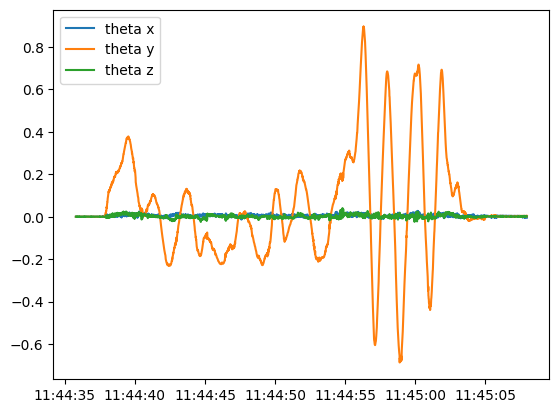

In [141]:
plt.plot(_m_df["time"], _theta_x, label="theta x")
plt.plot(_m_df["time"], _theta_y, label="theta y")
plt.plot(_m_df["time"], _theta_z, label="theta z")
plt.legend()


In [142]:
_w_df


,frame_id,x,y,z,yaw,pitch,roll,time
0,5.0,0.087509,0.161316,1.381840,-2.938610,0.012671,0.053643,2022-10-21 11:44:34.161344
1,5.0,0.096223,0.212332,1.820007,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.216345
2,5.0,0.096223,0.212332,1.820007,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.291344
3,5.0,0.096223,0.212332,1.820007,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.356345
4,5.0,0.087509,0.161316,1.381840,-2.938610,0.012671,0.053643,2022-10-21 11:44:34.419344
...,...,...,...,...,...,...,...,...
473,5.0,0.072051,0.168972,1.379685,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.745551
474,5.0,0.072051,0.168972,1.379685,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.825552
475,5.0,0.072051,0.168972,1.379685,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.886054
476,5.0,0.072051,0.168972,1.379685,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.950059


In [143]:
""" angle from aruco marker"""

_ar_rotmat_i = []
for i in range(len(_w_df)):
    
    _val = _w_df[["yaw", "pitch", "roll"]].loc[i].values
    _val = np.reshape(_val, (3,1))
    _ar_rotmat_i.append(cv2.Rodrigues(_val))



In [144]:
_webcam_rot.T @ _ar_rotmat_i[0][0]

array([[ 0.99318042, -0.03685795, -0.1106081 ],
       [ 0.02239604,  0.99135903, -0.12925052],
       [ 0.11441625,  0.1258919 ,  0.98542384]])

In [145]:
_del_ar_r = []

_rotmat_la_0 = _webcam_rot.T @ _ar_rotmat_i[0][0]
for i in range(len(_ar_rotmat_i)):
    _rotmat_la = _webcam_rot.T @ _ar_rotmat_i[i][0]
    _del_ar_r.append(_rotmat_la_0.T@_rotmat_la)

In [146]:
_del_ar_r = []

# _rotmat_la_0 = _webcam_rot.T @ _ar_rotmat_i[0][0]
for i in range(len(_ar_rotmat_i)):
    # _rotmat_la = _webcam_rot.T @ _ar_rotmat_i[i][0]
    _del_ar_r.append(_ar_rotmat_i[0][0].T@_ar_rotmat_i[i][0])

In [147]:
#getting angle from rotmat

_ar_theta_x = []
_ar_theta_y = []
_ar_theta_z = []

for i in _del_ar_r:
    _ar_theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _ar_theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _ar_theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_ar_theta_x = np.array(_ar_theta_x)
_ar_theta_y = np.array(_ar_theta_y)
_ar_theta_z = np.array(_ar_theta_z)

In [148]:
_ar_ang_df = pd.DataFrame({"time": _w_df["time"], "theta_x": _ar_theta_x, "theta_y": _ar_theta_y, "theta_z": _ar_theta_z})

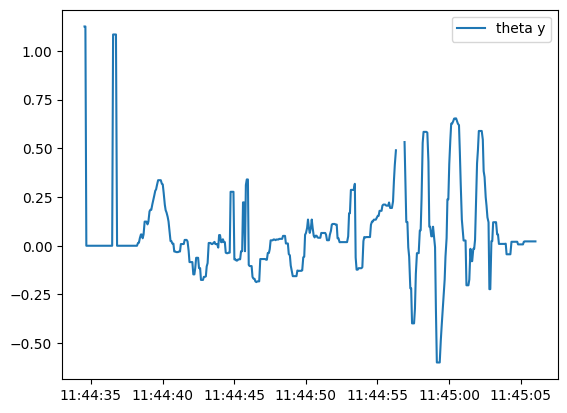

In [149]:
# plt.plot(_w_df["time"], _ar_ang_df["theta_x"].rolling(7).median(), label="theta x")
plt.plot(_w_df["time"], _ar_ang_df["theta_y"].rolling(7).median(), label="theta y")
# plt.plot(_w_df["time"], _ar_ang_df["theta_z"].rolling(7).median(), label="theta z")
plt.legend()

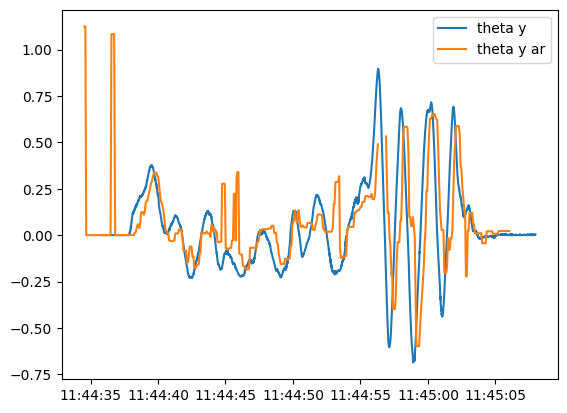

In [150]:
plt.plot(_m_df["time"], _theta_y, label="theta y")
plt.plot(_w_df["time"], _ar_ang_df["theta_y"].rolling(7).median(), label="theta y ar")
plt.legend()

Mecanum vs MoCap

In [151]:
radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

In [152]:
_sk_csv_pth = os.path.join(_pth, "imu01.csv")
_sk_df = pd.read_csv(_sk_csv_pth)


In [153]:
_sk_df = set_zero(_sk_df)
_sk_df, _ang_column = get_angular_velocity(_sk_df)
_sk_df, _ = get_directional_velocity(_sk_df, _ang_column, radius, lx, ly)
_sk_df, _ = get_position(_sk_df)


In [154]:
_sk_df["sys_time"] = pd.to_datetime(_sk_df["sys_time"])
_a = 0.085
_b = 0.15

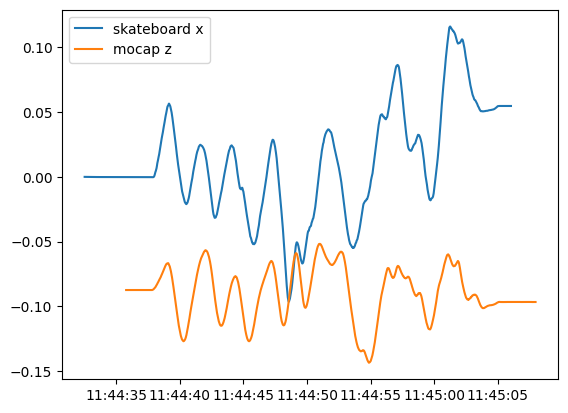

In [155]:
plt.plot(_sk_df["sys_time"],_sk_df["x_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["z"]*-0.25 - _a, label="mocap z")
plt.legend()


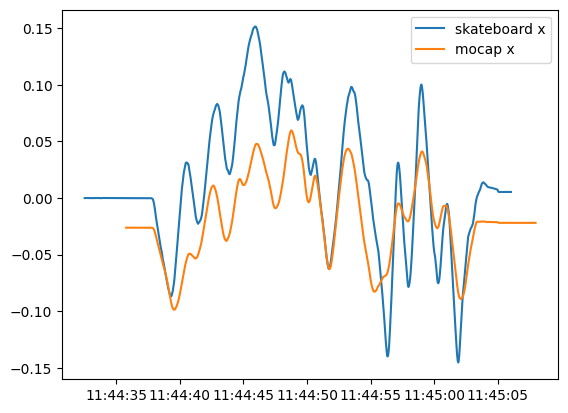

In [156]:
plt.plot(_sk_df["sys_time"],_sk_df["y_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["x"]*-0.25, label="mocap x")
plt.legend()


In [157]:
_tt = w_df[["yaw","pitch", "roll"]].iloc[100]
_tt

yaw     -2.973725
pitch    0.024147
roll     0.100316
Name: 100, dtype: float64

In [158]:
w_df

,frame_id,x,y,z,yaw,pitch,roll,time
0,5.0,0.089763,0.209942,0.012023,-2.938610,0.012671,0.053643,2022-10-21 11:44:34.161344
1,5.0,0.133499,0.127010,-0.419113,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.216345
2,5.0,0.133499,0.127010,-0.419113,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.291344
3,5.0,0.133499,0.127010,-0.419113,-7.805292,-0.334100,-5.430682,2022-10-21 11:44:34.356345
4,5.0,0.089763,0.209942,0.012023,-2.938610,0.012671,0.053643,2022-10-21 11:44:34.419344
...,...,...,...,...,...,...,...,...
473,5.0,0.074253,0.202236,0.013529,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.745551
474,5.0,0.074253,0.202236,0.013529,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.825552
475,5.0,0.074253,0.202236,0.013529,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.886054
476,5.0,0.074253,0.202236,0.013529,-3.059046,0.054267,0.028807,2022-10-21 11:45:05.950059


In [159]:
_temp = cv2.Rodrigues(np.array(_tt))
_temp = np.array(_temp[0])
_x = _temp.T[0]
_y = _temp.T[1]
_z = _temp.T[2]

_temp

array([[ 0.99761159, -0.02168244, -0.06558188],
       [-0.01053556, -0.98610981,  0.16576018],
       [-0.06826502, -0.16467333, -0.98398302]])

In [160]:
_r0 = w_df[["yaw","pitch", "roll"]].loc[0].values
_rotmat_r0 = cv2.Rodrigues(_r0)[0]
_rotmat_r0

array([[ 0.99930378, -0.01220285, -0.03525675],
       [-0.00486268, -0.97953699,  0.20120548],
       [-0.03699057, -0.20089395, -0.97891436]])

In [161]:
def transform_aruco_to_wheels(df):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        _rot_vec = df[["yaw","pitch", "roll"]].loc[i].values
        _rot_vec = np.array(_rot_vec)
        _rot_mat = cv2.Rodrigues(_rot_vec)[0]
        _rot_mat = np.array(_rot_mat)

        _del_rot_mat = _rotmat_r0.T@_rot_mat
        _xv = _del_rot_mat.T[0]
        _xv = np.reshape(_xv, (3,1))
        _yv = _del_rot_mat.T[1]
        _yv = np.reshape(_yv, (3,1))
        _zv = _del_rot_mat.T[2]
        _zv = np.reshape(_zv, (3,1))

        # translation vector
        _tv = df[["x", "y", "z"]].loc[i].values
        _tv = np.reshape(_tv, (3,1))

        # point in cart pc
        _a = 0.085
        _b = 0.15
        pc = _tv - _a*_zv + _b*_yv
        pc = pc.T[0]
        
        df1["x"].replace({df1["x"].loc[i]: pc[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: pc[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: pc[2]}, inplace=True)
    return df1

In [162]:
test_df = transform_aruco_to_wheels(w_df)

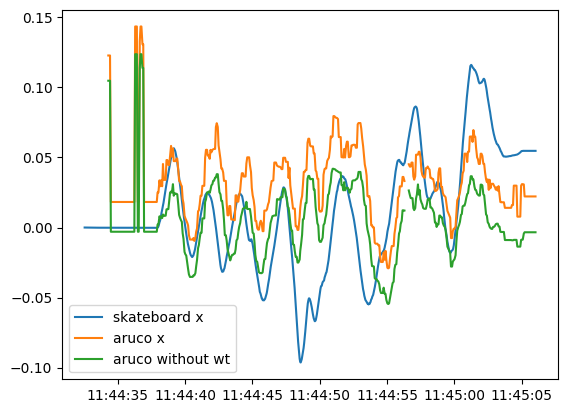

In [163]:
plt.plot(_sk_df["sys_time"],_sk_df["x_val"], label="skateboard x")
plt.plot(test_df["time"], test_df["z"].rolling(3).median()*-0.25, label="aruco x")
plt.plot(w_df["time"], w_df["z"].rolling(3).median()*-0.25, label="aruco without wt")
plt.legend()

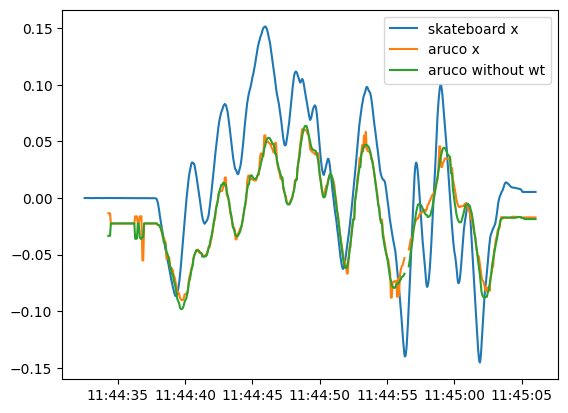

In [164]:
plt.plot(_sk_df["sys_time"],_sk_df["y_val"], label="skateboard x")
plt.plot(test_df["time"], test_df["x"].rolling(3).median()*-0.25 , label="aruco x")
plt.plot(w_df["time"], w_df["x"].rolling(3).median()*-0.25, label="aruco without wt")

plt.legend()